In [457]:
from datetime import datetime
import pandas as pd
import numpy as np

In [458]:
from datetime import date

def pretvori_datum_v_datetime(string_datuma):
    """
    Funkcija, ki obe vrsti datuma pretvori v ustretno datetime obliko (datum_izida in datum all_time_high/low)
    """
    
    # Za vsak slučaj
    if not string_datuma:
        return None
    
    # Ločimo primera 'Apr 29, 2022' in '2022-04-29'
    if "," in string_datuma:
        return datetime.strptime(string_datuma, "%b %d, %Y")
    else:
        return datetime.strptime(string_datuma, "%Y-%m-%d")
    
print(pretvori_datum_v_datetime("Apr 9, 2022"))
print(pretvori_datum_v_datetime("2022-04-09"))

2022-04-09 00:00:00
2022-04-09 00:00:00


In [459]:
def popravi_cardtype_aftermath(seznam_cardtypa):
    """
    Popravimo seznam cardtypa, ki se pojavi zaradi nenavadnega/nekonsistentnega zapisa Aftermath kart na spletni strani
    """
    if not seznam_cardtypa:
        return None
    
    popravljen_seznam = []
    for tip in seznam_cardtypa:
        if tip not in popravljen_seznam and "//" not in tip:
            popravljen_seznam.append(tip)
    return popravljen_seznam

print(popravi_cardtype_aftermath(["Sorcery", "//", "Sorcery"]))

['Sorcery']


In [460]:
def popravi_subtype_adventure(seznam_subtypa):
    """
    Popravimo seznam subtypa, ki se pojavi zaradi nenavadnega/nekonsistentnega zapisa Adventure kart na spletni strani
    """
    if not seznam_subtypa:
        return None
    
    popravljen_seznam = []
    for tip in seznam_subtypa:
        if "//" in tip:
                break
        elif tip not in popravljen_seznam:
            popravljen_seznam.append(tip)
    return popravljen_seznam

print(popravi_subtype_adventure(['Beast', 'Noble', '//', 'Sorcery']))

['Beast', 'Noble']


In [461]:
problematicni_tipi = ["Token", "Emblem"]
def vsebovanost_problematicnih_karte_na_podlagi_seznama(seznam, seznam_problematicnih_elementov = problematicni_tipi):
    """
    Preverimo, ali določen seznam vsebuje problematične elemente
    """
    
    vsebuje_problem = False
    for element in seznam:
        if element in seznam_problematicnih_elementov:
            vsebuje_problem = True
            break
    return vsebuje_problem

print(vsebovanost_problematicnih_karte_na_podlagi_seznama(["Nissa"], problematicni_tipi))

False


In [462]:
color_pentagon = "wubrg"

def zavrti_cikel(cikel,smer_urinega = True):
    if smer_urinega:
        return cikel[1:] + cikel[0]
    else:
        return cikel[-1] + cikel[:-1]

def razdalja_med_crkama_v_ciklu(prva_crka, druga_crka, niz_barve, smer_urinega = True):
    if niz_barve[color_pentagon.index(prva_crka)] == druga_crka:
        return 0
    else:
        return 1 + razdalja_med_crkama_v_ciklu(prva_crka, druga_crka, zavrti_cikel(niz_barve, smer_urinega), smer_urinega)


print(razdalja_med_crkama_v_ciklu("u","w", color_pentagon, smer_urinega=True))

def prvi_string_je_v_drugem(niz1, niz2):
    for crka in niz1:
        if crka not in niz2:
            return False
    return True

def popravi_vrstni_red_barve(niz_barve):
    # Izkaže se, da je še najlažje ločiti funkcijo glede na to, koliko barv je vsebovanih
    # Celoten postopek določanja vrstnega reda je opisan tule: https://magic.wizards.com/en/articles/archive/ask-wizards-june-2004-2004-06-01
    if not prvi_string_je_v_drugem(niz_barve, color_pentagon):
        return niz_barve
    if len(niz_barve) < 2 or len(niz_barve) > 5:
        return niz_barve
    if len(niz_barve) == 5:
        return color_pentagon
    if len(niz_barve) == 2:
        transpozicija_niza = niz_barve[::-1]
        if razdalja_med_crkama_v_ciklu(niz_barve[0], niz_barve[1], color_pentagon) > 2:
            return transpozicija_niza
        else:
            return niz_barve
    if len(niz_barve) == 4:
        manjka_barva = color_pentagon[::]
        for crka in niz_barve:
            if crka not in manjka_barva:
                return niz_barve
            else:
                manjka_barva = manjka_barva.replace(crka, "")
        kopija_pentagona = color_pentagon[::]
        while kopija_pentagona[-1] != manjka_barva:
            kopija_pentagona = zavrti_cikel(kopija_pentagona)
        return kopija_pentagona.replace(manjka_barva, "")
    if len(niz_barve) == 3:
        # Tule je napaka!!
        string_barv_v_pravem_redu = ""
        for barva in color_pentagon:
            if barva in niz_barve:
                string_barv_v_pravem_redu += barva 
        while razdalja_med_crkama_v_ciklu(string_barv_v_pravem_redu[2], string_barv_v_pravem_redu[0], color_pentagon) == 1:
            string_barv_v_pravem_redu = zavrti_cikel(string_barv_v_pravem_redu)
        if razdalja_med_crkama_v_ciklu(string_barv_v_pravem_redu[2], string_barv_v_pravem_redu[0], color_pentagon) == 3:
            return string_barv_v_pravem_redu
        kopija_pentagona = color_pentagon[::]
        while not prvi_string_je_v_drugem(string_barv_v_pravem_redu, kopija_pentagona[::2]):
            kopija_pentagona = zavrti_cikel(kopija_pentagona)
        return kopija_pentagona[::2]
            
        
print(popravi_vrstni_red_barve("ubw"))

def popravi_barvo_karte(niz_barve, niz_oracle_texta, niz_cardtypa):
    """
    Ta funkcija vzame string barve, ki ga ustrezno popravi glede na oracle text + vrsntni red barv (UW -> WU)
    """
    if not niz_barve or "Land" in niz_cardtypa:
        return "c"
    
    for barva in color_pentagon:
        if barva not in niz_barve:
            if f"({barva})" in niz_oracle_texta:
                niz_barve += barva
    # Odpravimo možnost colorless.
    if len(niz_barve) >= 2:
        niz_barve = niz_barve.replace("c","")
    return popravi_vrstni_red_barve(niz_barve)

4
wub


# Zdaj hočemo narediti podatkovno bazo z merganjem dveh dataframov

In [463]:
slovar_za_popravljanje_napacnih_podatkov_s_spletne_strani = {'set': {"VAN" : "PVAN", "SLDC": "PHED", "XCLE": "CED", "XICE": "CEI", "RMB1": "FMB1", "XDND" : "AFR", "2E": "LEB", "2U": "2ED", "1E": "LEA", "PO2": "P02", "3ED":"FBB", "3E":"3ED"}}

osnovni_podatki_o_kartah = pd.read_csv("karte.csv").replace(slovar_za_popravljanje_napacnih_podatkov_s_spletne_strani)
dodatni_podatki_o_kartah = pd.read_csv("specificne_lastnosti_kart.csv")
dodatni_podatki_o_setih = pd.read_csv("seti.csv").replace(slovar_za_popravljanje_napacnih_podatkov_s_spletne_strani)

print(dodatni_podatki_o_setih)

podatkovna_baza = pd.merge(osnovni_podatki_o_kartah, dodatni_podatki_o_kartah)
podatkovna_baza = pd.merge(podatkovna_baza, dodatni_podatki_o_setih)

# koliko je sploh smiselno družiti take podatke med sabo?
# V resnici ni čisto jasno

%reset_selective -f osnovni_podatki_o_kartah
%reset_selective -f dodatni_podatki_o_kartah
%reset_selective -f dodatni_podatki_o_setih

     set               polno_ime  st_kart datum_izida
0    RTR       Return to Ravnica      274  2012-10-05
1    ZEN                Zendikar      269  2009-10-02
2    BRB   Battle Royale Box Set      136  1999-11-12
3    SNC  Streets of New Capenna      510  2022-04-29
4    NCC   New Capenna Commander      447  2022-04-29
..   ...                     ...      ...         ...
221  S00            Starter 2000       20  2000-04-01
222  POR                  Portal      256  1997-05-01
223  P02       Portal Second Age      165  1998-06-24
224  PTK   Portal Three Kingdoms      180  1999-07-06
225  ARC               Archenemy      150  2010-06-18

[226 rows x 4 columns]


Zdaj malo popravimo tabelo s funckijami, ki smo jih napisali.

In [464]:
podatkovna_baza["cardtype"] = podatkovna_baza["cardtype"].apply(lambda x: popravi_cardtype_aftermath(x[1:-1].split(', ')) if type(x) == str else x)
podatkovna_baza["subtype"] = podatkovna_baza["subtype"].apply(lambda x: popravi_subtype_adventure(x[1:-1].split(', ')) if type(x) == str else x)
podatkovna_baza["reserved_list"] = podatkovna_baza["reserved_list"].apply(lambda x: x == "Yes")
# Moram ugotoviti, kako se spodnje 3 vrstice zapiše v enem koraku
podatkovna_baza["all_time_low_datum"] = podatkovna_baza["all_time_low_datum"].apply(lambda x: pd.to_datetime(pretvori_datum_v_datetime(x)) if type(x) == str else x)
podatkovna_baza["all_time_high_datum"] = podatkovna_baza["all_time_high_datum"].apply(lambda x: pd.to_datetime(pretvori_datum_v_datetime(x)) if type(x) == str else x)
podatkovna_baza["datum_izida"] = podatkovna_baza["datum_izida"].apply(lambda x: pd.to_datetime(pretvori_datum_v_datetime(x)) if type(x) == str else x)

podatkovna_baza["barva"] = podatkovna_baza.apply(lambda x: popravi_barvo_karte(str(x.barva), str(x.oracle_text), str(x.cardtype)), axis = 1)

seznam_stolpcev_cen = ["povprecna_cena", "povprecna_cena_foil", "povprecje_eu", "all_time_low", "all_time_high"]
for cena in seznam_stolpcev_cen:
    podatkovna_baza[cena] = podatkovna_baza[cena].apply(lambda x: (float(x[1:])) if (type(x) != float) else x).replace("nan","NaN") # Tole je seveda treba popraviti, da ne bo grdo

#podatkovna_baza["cardtype"] = podatkovna_baza["cardtype"].apply(lambda x: vsebovanost_problematicnih_karte_na_podlagi_seznama(x[1:-1].split(',')) if type(x) == str else x)

podatkovna_baza.to_json("popolni_podatki_o_kartah.json", orient='records', indent=4)

       id_karte               ime  set   redkost  povprecna_cena  \
0         19748     Cyclonic Rift  RTR      Rare           38.00   
1         19934   Utvara Hellkite  RTR    Mythic           19.53   
2           360       Blood Crypt  RTR      Rare           19.99   
3           404       Steam Vents  RTR      Rare           18.63   
4           395    Overgrown Tomb  RTR      Rare           13.99   
...         ...               ...  ...       ...             ...   
43007     18337  Dregscape Zombie  ARC    Common            0.25   
43008     18380        Juggernaut  ARC  Uncommon            0.25   
43009     18421           Plummet  ARC    Common            0.25   
43010     18348          Fertilid  ARC    Common            0.38   
43011     18434  Sanctum Gargoyle  ARC    Common            0.24   

       povprecna_cena_foil  cmc manacost barva  povprecje_eu  ...  \
0                    57.99    2       1u     u         24.77  ...   
1                    57.44    8      6rr     

<AxesSubplot: xlabel='povprecje_eu'>

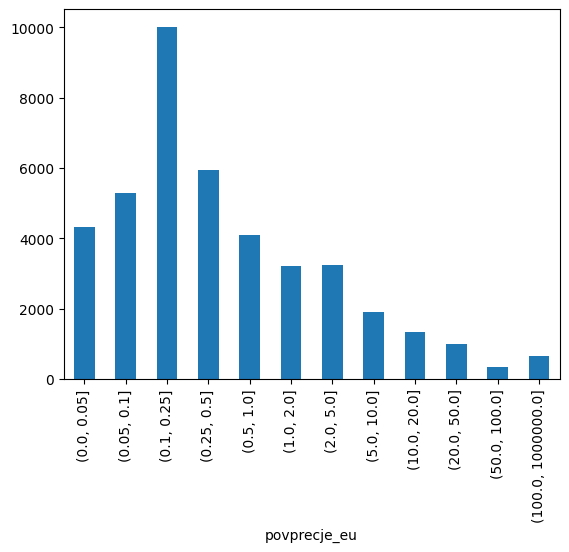

In [515]:
cenovni_razredi_kart = np.array([0, 0.05, 0.10, 0.25, 0.5, 1, 2, 5, 10, 20, 50, 100, 1000000])
podatki_po_ceni_eu = podatkovna_baza.groupby(pd.cut(podatkovna_baza["povprecje_eu"], cenovni_razredi_kart)).size()
podatki_po_ceni_us = podatkovna_baza.groupby(pd.cut(podatkovna_baza["povprecna_cena"], cenovni_razredi_kart)).size()
#pd.merge(podatki_po_ceni_eu, podatki_po_ceni_us).plot(kind = "bar")
podatki_po_ceni_eu.plot(kind = "bar")

# Tukaj je treba porihtati, da dobimo primerjavo ameriških cenovnih razredov z evropskimi